# Import and description

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import load_boston
data_load = load_boston()

In [3]:
print(data_load.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [4]:
from sklearn.preprocessing import FunctionTransformer

data = pd.DataFrame(data_load['data'], columns=data_load['feature_names']) 
target = data_load['target']

category_col = ['B']
numeric_col = [col for col in data.columns.to_list() if col not in category_col]

def get_numeric_data_helper(x):
    return x[category_col]

def get_category_data_helper(x):
    return x[numeric_col]

get_numeric_data = FunctionTransformer(get_numeric_data_helper, validate=False)
get_category_data = FunctionTransformer(get_category_data_helper, validate=False)

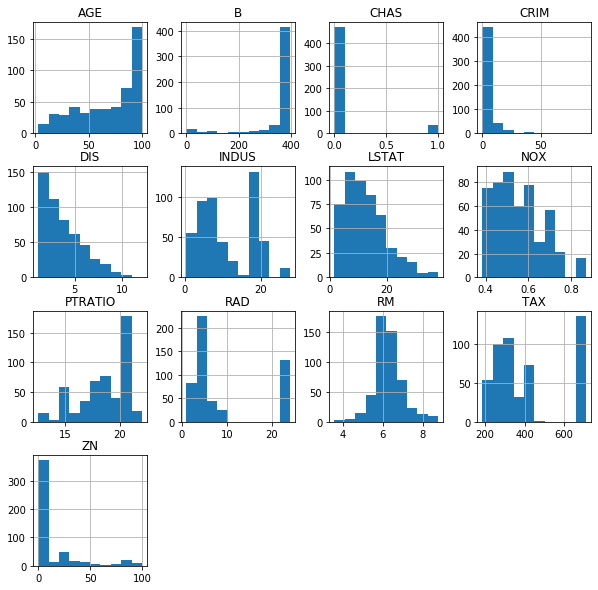

In [94]:
data.hist(figsize=(10, 10));

22.532806324110677 9.188011545278203


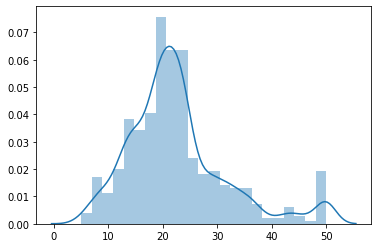

In [46]:
print(np.mean(target), np.std(target))
sns.distplot(target)

# Linear regression

In [115]:
# without tuning
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

regression = LinearRegression()
score = cross_val_score(regression, data, target, scoring='neg_mean_absolute_error', cv=10)
print("-MAE: %.3f, (%.3f)" % (np.mean(score), np.std(score)))

-MAE: -4.005, (2.084)


In [16]:
# tuning
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, FunctionTransformer, PolynomialFeatures
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_selection import f_regression, SelectPercentile



feature_preprocessing = FeatureUnion([
    ('category_data', get_category_data),
    ('numeric_data', Pipeline([
        ('get_numeric_data', get_numeric_data),
        ('std', StandardScaler())      
    ]))
])

model_pipe = Pipeline([
    ('feature_preprocessing', feature_preprocessing),
    ('interaction', PolynomialFeatures(interaction_only=True, include_bias=False)), 
    ('featue_select', SelectPercentile(score_func=f_regression)),
    ('linear_model', ElasticNet())
])

alpha = np.logspace(-2, 2, 5)
l1_ratio = np.arange(0, 1.1, 0.1)
percentile = np.arange(1, 22, 3)
params = {
    'linear_model__alpha': alpha,
    'linear_model__l1_ratio': l1_ratio,
    'featue_select__percentile': percentile
}

model_cv = GridSearchCV(model_pipe, param_grid=params, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [17]:
model_cv.fit(data, target)
print(model_cv.best_params_)
print(model_cv.best_score_)

{'featue_select__percentile': 13, 'linear_model__alpha': 0.01, 'linear_model__l1_ratio': 1.0}
-3.436838196015799


C:\Users\Amo.CH.Liu\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4883.350324820806, tolerance: 4.2716295415019765
  positive)


# SVM

In [11]:
from sklearn.svm import SVR
# from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, FunctionTransformer, PolynomialFeatures
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_selection import f_regression, SelectPercentile

feature_preprocessing = FeatureUnion([
    ('category_data', get_category_data),
    ('numeric_data', Pipeline([
        ('get_numeric_data', get_numeric_data),
        ('std', StandardScaler())      
    ]))
])

model_pipe = Pipeline([
    ('feature_preprocessing', feature_preprocessing),
    ('interaction', PolynomialFeatures(interaction_only=True, include_bias=False)), 
    ('featue_select', SelectPercentile(score_func=f_regression)),
    ('svm', SVR())
])

C = np.logspace(-2, 2, 5)
tol = np.logspace(-4, -2, 3)
gamma = ['scale', 'auto']
epsilon = np.logspace(-2, 2, 5)
# kernel = ['linear', 'poly', 'rbf']
percentile = np.arange(1, 22, 3)

params = {
    'svm__C': C,
    'svm__tol': tol,
    'svm__gamma': gamma,
    'svm__epsilon': epsilon,
#     'svm__kernel': kernel,
    'featue_select__percentile': percentile
}

# model_cv = RandomizedSearchCV(model_pipe, param_distributions=params, scoring='neg_mean_absolute_error', cv=5,
#                               n_iter=50, n_jobs=-1)

model_cv = GridSearchCV(model_pipe, params, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
model_cv.fit(data, target)
print(model_cv.best_params_)
print(model_cv.best_score_)

{'featue_select__percentile': 10, 'svm__C': 100.0, 'svm__epsilon': 1.0, 'svm__gamma': 'scale', 'svm__tol': 0.001}
-4.072169888977014


# Random forest regressor

In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_selection import f_regression, SelectPercentile

feature_preprocessing = FeatureUnion([
    ('category_data', get_category_data),
    ('numeric_data', Pipeline([
        ('get_numeric_data', get_numeric_data),
#         ('std', StandardScaler())      
    ]))
])

model_pipe = Pipeline([
    ('feature_preprocessing', feature_preprocessing),
    ('interaction', PolynomialFeatures(interaction_only=True, include_bias=False)), 
    ('featue_select', SelectPercentile(score_func=f_regression)),
    ('rfg', RandomForestRegressor(criterion='mae', n_jobs=-1))
])


n_estimators = [50, 100, 150, 200]
max_features = ['sqrt', 'log2', None]
# min_samples_split = [2, 4, 8, 16]
# min_samples_leaf = [1, 2, 4, 8]
min_impurity_decrease = np.arange(0, 0.05, 0.01)
percentile = np.arange(10, 23, 3)

params = {
    'rfg__n_estimators': n_estimators,
    'rfg__max_features': max_features,
#     'rfg__min_samples_split': min_samples_split,
#     'rfg__min_samples_leaf': min_samples_leaf,
    'rfg__min_impurity_decrease': min_impurity_decrease,
    'featue_select__percentile': percentile
}

# model_cv = RandomizedSearchCV(model_pipe, param_distributions=params, scoring='neg_mean_absolute_error', cv=5,
#                               n_iter=50, n_jobs=-1)

model_cv = GridSearchCV(model_pipe, params, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
model_cv.fit(data, target)
print(model_cv.best_params_)

print(model_cv.best_score_)

{'featue_select__percentile': 19, 'rfg__max_features': 'log2', 'rfg__min_impurity_decrease': 0.0, 'rfg__n_estimators': 100}
-3.0007387691710345


In [29]:
# from sklearn.externals import joblib
# joblib.dump(model_cv.best_estimator_, 'model/grid_search_rfg.pkl')

C:\Users\Amo.CH.Liu\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


PicklingError: Can't pickle <function <lambda> at 0x0000022138F18EA0>: it's not found as __main__.<lambda>

In [26]:
# Validate model on 10 fold cv
from sklearn.model_selection import cross_validate, StratifiedKFold

model_chosen = model_cv.best_estimator_
kfold = StratifiedKFold(n_splits=10, shuffle=True)

scoring = {'mae': 'neg_mean_absolute_error',
           'mse': 'neg_mean_squared_error'
          }

cv_result = cross_validate(model_chosen, data, target, scoring=scoring, cv=10)

C:\Users\Amo.CH.Liu\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\Amo.CH.Liu\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\Amo.CH.Liu\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\Amo.CH.Liu\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


KeyError: 'mae'

In [28]:
mae = cv_result['test_mae']
mse = cv_result['test_mse']
print("-MAE: %.3f, (%.3f)" % (np.mean(mae), np.std(mae)))
print("-MSE: %.3f, (%.3f)" % (np.mean(mse), np.std(mse)))

-MAE: -2.990, (1.062)
-MSE: -19.670, (19.843)


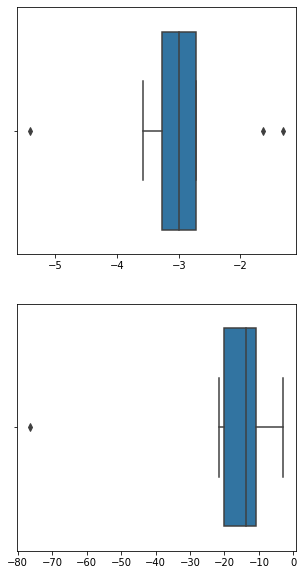

In [42]:
f, axes = plt.subplots(2, 1, figsize=(5, 10), sharex=False)

sns.boxplot(mae,  ax=axes[0]);
sns.boxplot(mse,  ax=axes[1]);

# XGBOOST

In [20]:
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import  PolynomialFeatures
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_selection import f_regression, SelectPercentile

In [27]:
xgb = XGBRegressor(n_estimators=10, max_depth=2, eta=1, objective='reg:squarederror', n_jobs=-1)
k_fold = KFold(10)

model_pipe = Pipeline([
    ('interaction', PolynomialFeatures(interaction_only=True, include_bias=False)), 
    ('featue_select', SelectPercentile(score_func=f_regression)),
    ('xgb', XGBRegressor())
])


n_estimators = [100, 150, 200]
max_depth = [2, 4]
eta = np.logspace(-2, 0, 3)
percentile = np.arange(20, 80, 10)

params = {
    'xgb__n_estimators': n_estimators,
    'xgb__max_depth': max_depth,
    'xgb__eta': eta,
    'featue_select__percentile': percentile
}

model_cv = GridSearchCV(model_pipe, params, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
model_cv.fit(data, target)

print(model_cv.best_params_)
print(model_cv.best_score_)

{'featue_select__percentile': 60, 'xgb__eta': 0.1, 'xgb__max_depth': 2, 'xgb__n_estimators': 200}
-2.951160256391913


# Gradient Boosting

C:\Users\Amo.CH.Liu\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\Amo.CH.Liu\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\Amo.CH.Liu\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\Amo.CH.Liu\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


-3.0403194274431145


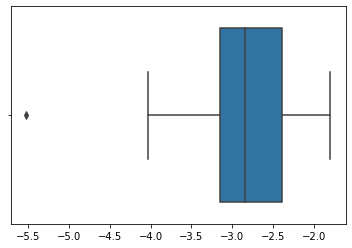

In [58]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_validate, StratifiedKFold

feature_preprocessing = FeatureUnion([
    ('category_data', get_category_data),
    ('numeric_data', Pipeline([
        ('get_numeric_data', get_numeric_data),
        ('std', StandardScaler())      
    ]))
])


model_pipe = Pipeline([
    ('feature_preprocessing', feature_preprocessing),
    ('interaction', PolynomialFeatures(interaction_only=True, include_bias=False)), 
    ('featue_select', SelectPercentile(percentile=20, score_func=f_regression)),
    ('gbr', GradientBoostingRegressor(n_estimators=150))
])

kfold = StratifiedKFold(n_splits=10, shuffle=True)
cv_result = cross_validate(model_pipe, data, target, scoring='neg_mean_absolute_error', cv=10)
print(np.mean(cv_result['test_score']))
sns.boxplot(cv_result['test_score']);

# Neural Network

In [54]:
from keras.layers import Dense
from keras import Sequential
from keras.optimizers import Adam
from keras.losses import Huber
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

def build_nn_model():
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(data.shape[1], )))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1))
    
    optimizer = Adam()
    
    model.compile(loss=Huber(), optimizer=optimizer, metrics=['mae'])
    return model

In [55]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

feature_preprocessing = FeatureUnion([
    ('category_data', get_category_data),
    ('numeric_data', Pipeline([
        ('get_numeric_data', get_numeric_data),
        ('std', StandardScaler())      
    ]))
])

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.1)

X_train = feature_preprocessing.fit_transform(X_train)
X_test = feature_preprocessing.transform(X_test)

In [57]:
early_stop = EarlyStopping(patience=30, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=15, min_lr=0.001)
nn_model = build_nn_model()
history = nn_model.fit(X_train,
                       y_train,
                       batch_size=1,
                       epochs=300,
                       validation_split=0.1,
                       verbose=2,
                       callbacks=[early_stop]
                      )

Train on 409 samples, validate on 46 samples
Epoch 1/300
 - 2s - loss: 13.7669 - mae: 14.2595 - val_loss: 13.8138 - val_mae: 14.3062
Epoch 2/300
 - 1s - loss: 8.0255 - mae: 8.5176 - val_loss: 9.8532 - val_mae: 10.3350
Epoch 3/300
 - 1s - loss: 6.5392 - mae: 7.0147 - val_loss: 5.9277 - val_mae: 6.4149
Epoch 4/300
 - 1s - loss: 5.5356 - mae: 6.0118 - val_loss: 6.8952 - val_mae: 7.3892
Epoch 5/300
 - 1s - loss: 5.9446 - mae: 6.4331 - val_loss: 5.6019 - val_mae: 6.0777
Epoch 6/300
 - 1s - loss: 5.3674 - mae: 5.8465 - val_loss: 5.0681 - val_mae: 5.5271
Epoch 7/300
 - 1s - loss: 4.8362 - mae: 5.3129 - val_loss: 5.5773 - val_mae: 6.0595
Epoch 8/300
 - 1s - loss: 4.6287 - mae: 5.1125 - val_loss: 5.2342 - val_mae: 5.7084
Epoch 9/300
 - 1s - loss: 4.8786 - mae: 5.3584 - val_loss: 3.9697 - val_mae: 4.4464
Epoch 10/300
 - 1s - loss: 4.7113 - mae: 5.1906 - val_loss: 4.4912 - val_mae: 4.9464
Epoch 11/300
 - 1s - loss: 4.5195 - mae: 4.9925 - val_loss: 4.8286 - val_mae: 5.3184
Epoch 12/300
 - 1s - los

Epoch 97/300
 - 1s - loss: 2.1433 - mae: 2.5821 - val_loss: 1.9855 - val_mae: 2.4398
Epoch 98/300
 - 1s - loss: 2.2732 - mae: 2.7258 - val_loss: 2.5352 - val_mae: 3.0085
Epoch 99/300
 - 1s - loss: 2.1029 - mae: 2.5595 - val_loss: 2.0904 - val_mae: 2.5454
Epoch 100/300
 - 1s - loss: 2.1982 - mae: 2.6610 - val_loss: 2.4437 - val_mae: 2.9183
Epoch 101/300
 - 1s - loss: 2.1084 - mae: 2.5511 - val_loss: 2.6640 - val_mae: 3.1411
Epoch 102/300
 - 1s - loss: 2.3124 - mae: 2.7586 - val_loss: 1.9883 - val_mae: 2.4251
Epoch 103/300
 - 1s - loss: 2.1499 - mae: 2.5882 - val_loss: 1.8023 - val_mae: 2.2363
Epoch 104/300
 - 1s - loss: 2.1968 - mae: 2.6446 - val_loss: 2.0835 - val_mae: 2.5311
Epoch 105/300
 - 1s - loss: 2.1679 - mae: 2.6187 - val_loss: 1.9568 - val_mae: 2.4164
Epoch 106/300
 - 1s - loss: 2.3831 - mae: 2.8445 - val_loss: 1.8061 - val_mae: 2.2805
Epoch 107/300
 - 1s - loss: 2.2515 - mae: 2.7051 - val_loss: 1.8642 - val_mae: 2.2903
Epoch 108/300
 - 1s - loss: 2.1673 - mae: 2.6282 - val_lo

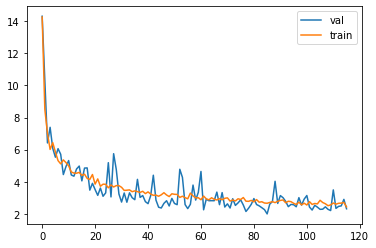

In [58]:
import matplotlib.pyplot as plt

val_mae = history.history['val_mae']
train_mae = history.history['mae']

plt.plot(val_mae)
plt.plot(train_mae)
plt.legend(['val', 'train']);

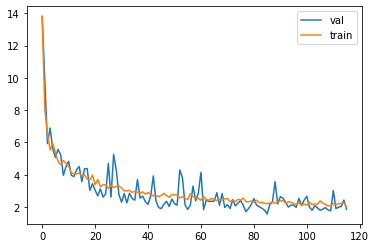

In [59]:
val_loss = history.history['val_loss']
train_loss = history.history['loss']

plt.plot(val_loss)
plt.plot(train_loss)
plt.legend(['val', 'train']);

In [60]:
# validation
from sklearn.metrics import mean_absolute_error
pred = nn_model.predict(X_test)
mae = mean_absolute_error(y_test, pred)
print(mae)

2.492443944893631


In [20]:
#cv

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import FeatureUnion, Pipeline

feature_preprocessing = FeatureUnion([
    ('category_data', get_category_data),
    ('numeric_data', Pipeline([
        ('get_numeric_data', get_numeric_data),
        ('std', StandardScaler())      
    ]))
])

early_stop = EarlyStopping(patience=40, restore_best_weights=True)

k_fold = KFold(5)

MAE = []
for trn_idx, val_idx in k_fold.split(data):
    nn_model = build_nn_model()

    X_train, X_test = data.iloc[trn_idx, :], data.iloc[val_idx]
    y_train, y_test = target[trn_idx], target[val_idx]

    X_train = feature_preprocessing.fit_transform(X_train)
    X_test = feature_preprocessing.transform(X_test)

    nn_model.fit(X_train,
                 y_train,
                 batch_size=1,
                 epochs=150,
                 validation_split=0.1,
                 verbose=2,
                 callbacks=[early_stop]
                )
    
    pred = nn_model.predict(X_test)
    MAE.append(mean_absolute_error(y_test, pred))

print(MAE)
print(np.mean(MAE), np.std(MAE))

Train on 363 samples, validate on 41 samples
Epoch 1/150
 - 1s - loss: 10.9085 - mae: 11.4000 - val_loss: 13.5857 - val_mae: 14.0857
Epoch 2/150
 - 1s - loss: 8.1769 - mae: 8.6631 - val_loss: 5.6933 - val_mae: 6.1813
Epoch 3/150
 - 1s - loss: 7.7250 - mae: 8.2135 - val_loss: 5.0012 - val_mae: 5.5003
Epoch 4/150
 - 1s - loss: 7.3307 - mae: 7.8155 - val_loss: 15.2920 - val_mae: 15.7813
Epoch 5/150
 - 1s - loss: 6.2803 - mae: 6.7590 - val_loss: 11.7457 - val_mae: 12.2389
Epoch 6/150
 - 1s - loss: 7.1907 - mae: 7.6753 - val_loss: 6.1548 - val_mae: 6.6468
Epoch 7/150
 - 1s - loss: 5.6720 - mae: 6.1497 - val_loss: 4.1485 - val_mae: 4.6355
Epoch 8/150
 - 1s - loss: 5.7195 - mae: 6.1988 - val_loss: 3.3577 - val_mae: 3.8355
Epoch 9/150
 - 1s - loss: 5.1150 - mae: 5.5882 - val_loss: 2.9612 - val_mae: 3.4359
Epoch 10/150
 - 1s - loss: 5.2334 - mae: 5.7025 - val_loss: 4.7152 - val_mae: 5.1864
Epoch 11/150
 - 1s - loss: 5.2142 - mae: 5.6918 - val_loss: 3.2135 - val_mae: 3.6873
Epoch 12/150
 - 1s - 

Epoch 3/150
 - 1s - loss: 6.1473 - mae: 6.6329 - val_loss: 3.9528 - val_mae: 4.4324
Epoch 4/150
 - 1s - loss: 6.2231 - mae: 6.7069 - val_loss: 3.8004 - val_mae: 4.2685
Epoch 5/150
 - 1s - loss: 5.6414 - mae: 6.1193 - val_loss: 3.1067 - val_mae: 3.5554
Epoch 6/150
 - 1s - loss: 5.2976 - mae: 5.7767 - val_loss: 3.7419 - val_mae: 4.2114
Epoch 7/150
 - 1s - loss: 4.8874 - mae: 5.3615 - val_loss: 4.2386 - val_mae: 4.7382
Epoch 8/150
 - 1s - loss: 5.0540 - mae: 5.5320 - val_loss: 3.2358 - val_mae: 3.6990
Epoch 9/150
 - 1s - loss: 4.6514 - mae: 5.1251 - val_loss: 3.2429 - val_mae: 3.7022
Epoch 10/150
 - 1s - loss: 4.3725 - mae: 4.8482 - val_loss: 5.0260 - val_mae: 5.5216
Epoch 11/150
 - 1s - loss: 4.3274 - mae: 4.8027 - val_loss: 5.1338 - val_mae: 5.6097
Epoch 12/150
 - 1s - loss: 4.0634 - mae: 4.5432 - val_loss: 4.6713 - val_mae: 5.1635
Epoch 13/150
 - 1s - loss: 4.0271 - mae: 4.4983 - val_loss: 4.3753 - val_mae: 4.8660
Epoch 14/150
 - 1s - loss: 4.0848 - mae: 4.5604 - val_loss: 5.4443 - val

Epoch 100/150
 - 1s - loss: 2.1136 - mae: 2.5558 - val_loss: 2.7981 - val_mae: 3.2692
Epoch 101/150
 - 1s - loss: 2.0788 - mae: 2.5197 - val_loss: 2.7552 - val_mae: 3.2114
Epoch 102/150
 - 1s - loss: 2.2291 - mae: 2.6860 - val_loss: 2.8023 - val_mae: 3.2563
Epoch 103/150
 - 1s - loss: 2.1763 - mae: 2.6240 - val_loss: 3.0185 - val_mae: 3.4813
Epoch 104/150
 - 1s - loss: 2.1427 - mae: 2.5820 - val_loss: 3.0536 - val_mae: 3.5317
Epoch 105/150
 - 1s - loss: 2.2409 - mae: 2.6894 - val_loss: 2.8326 - val_mae: 3.2735
Epoch 106/150
 - 1s - loss: 2.1340 - mae: 2.5829 - val_loss: 2.6845 - val_mae: 3.1173
Epoch 107/150
 - 1s - loss: 2.2047 - mae: 2.6600 - val_loss: 4.0546 - val_mae: 4.5286
Epoch 108/150
 - 1s - loss: 2.1367 - mae: 2.5817 - val_loss: 2.8272 - val_mae: 3.3047
Epoch 109/150
 - 1s - loss: 2.1831 - mae: 2.6287 - val_loss: 6.0323 - val_mae: 6.5310
Epoch 110/150
 - 1s - loss: 2.3589 - mae: 2.8162 - val_loss: 2.8228 - val_mae: 3.2969
Epoch 111/150
 - 1s - loss: 2.0212 - mae: 2.4691 - val

Train on 364 samples, validate on 41 samples
Epoch 1/150
 - 1s - loss: 10.7849 - mae: 11.2767 - val_loss: 8.6750 - val_mae: 9.1732
Epoch 2/150
 - 1s - loss: 7.7374 - mae: 8.2304 - val_loss: 4.3282 - val_mae: 4.7890
Epoch 3/150
 - 1s - loss: 8.1272 - mae: 8.6129 - val_loss: 3.7311 - val_mae: 4.2030
Epoch 4/150
 - 1s - loss: 6.7363 - mae: 7.2202 - val_loss: 4.0777 - val_mae: 4.5488
Epoch 5/150
 - 1s - loss: 5.7116 - mae: 6.1904 - val_loss: 12.0094 - val_mae: 12.5038
Epoch 6/150
 - 1s - loss: 6.1069 - mae: 6.5840 - val_loss: 7.1884 - val_mae: 7.6870
Epoch 7/150
 - 1s - loss: 5.1159 - mae: 5.5924 - val_loss: 6.3469 - val_mae: 6.8469
Epoch 8/150
 - 1s - loss: 4.8285 - mae: 5.3027 - val_loss: 3.0251 - val_mae: 3.4966
Epoch 9/150
 - 1s - loss: 5.0958 - mae: 5.5747 - val_loss: 4.7646 - val_mae: 5.2580
Epoch 10/150
 - 1s - loss: 4.8831 - mae: 5.3534 - val_loss: 6.2255 - val_mae: 6.7122
Epoch 11/150
 - 1s - loss: 4.5963 - mae: 5.0781 - val_loss: 3.9340 - val_mae: 4.4135
Epoch 12/150
 - 1s - loss

Epoch 49/150
 - 1s - loss: 2.3554 - mae: 2.8121 - val_loss: 5.8923 - val_mae: 6.3565
Epoch 50/150
 - 1s - loss: 2.1042 - mae: 2.5533 - val_loss: 6.2667 - val_mae: 6.7399
Epoch 51/150
 - 1s - loss: 2.1734 - mae: 2.6218 - val_loss: 7.7317 - val_mae: 8.2182
Epoch 52/150
 - 1s - loss: 2.2607 - mae: 2.7085 - val_loss: 6.9563 - val_mae: 7.4496
Epoch 53/150
 - 1s - loss: 2.0548 - mae: 2.5036 - val_loss: 6.2450 - val_mae: 6.7174
Epoch 54/150
 - 1s - loss: 2.1931 - mae: 2.6543 - val_loss: 5.7589 - val_mae: 6.2225
Epoch 55/150
 - 1s - loss: 2.1015 - mae: 2.5562 - val_loss: 6.8376 - val_mae: 7.3324
Epoch 56/150
 - 1s - loss: 2.2687 - mae: 2.7308 - val_loss: 7.2050 - val_mae: 7.6980
Epoch 57/150
 - 1s - loss: 2.0068 - mae: 2.4551 - val_loss: 6.9113 - val_mae: 7.4111
Epoch 58/150
 - 1s - loss: 2.0214 - mae: 2.4801 - val_loss: 6.1132 - val_mae: 6.6037
Epoch 59/150
 - 1s - loss: 2.2077 - mae: 2.6633 - val_loss: 7.6558 - val_mae: 8.1385
Epoch 60/150
 - 1s - loss: 1.9000 - mae: 2.3416 - val_loss: 7.103